# Factory Electric Consumption Prediction
Forecast the electric consumption of a factory based on historical data. The goal is to develop a predictive model that provides accurate ele
ctricity consumption forecasts to improve energy efficiency, plan resource allocation, and identify seasonal patterns or trends.
### Objective
- Predict Factory Electric Consumption using a regression model.
- Training data: 13,872 records
- Test data: 2,160 records
- Evaluation metric: RMSE 

## Libraries Used

In [ ]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns


## Data Exploration

In [2]:
# Upload the data
train_df = pd.read_csv("../Data/train_df.csv")
test_df = pd.read_csv("../Data/test_df.csv")

# Convert Date column to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Statistics
display(train_df.describe())

,Electric_Consumption,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F
count,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000
mean,5.893120,2.262227,19.977867,40.332796,145.005668,0.209435,42.522214
std,7.355969,1.457234,9.607866,24.324671,94.993992,1.691576,280.466514
min,-0.009717,-74.220598,-5.422289,3.249366,-1380.363752,0.000000,0.000000
25%,0.000000,1.105756,13.088434,20.396742,106.883078,0.000000,0.579665
50%,0.086858,1.995936,20.187978,34.024351,138.044038,0.000000,1.981719
75%,13.512742,3.261530,26.994172,57.191932,209.901463,0.000000,60.123072
max,21.360638,8.392045,44.036205,101.706771,312.895406,31.000006,31839.840610


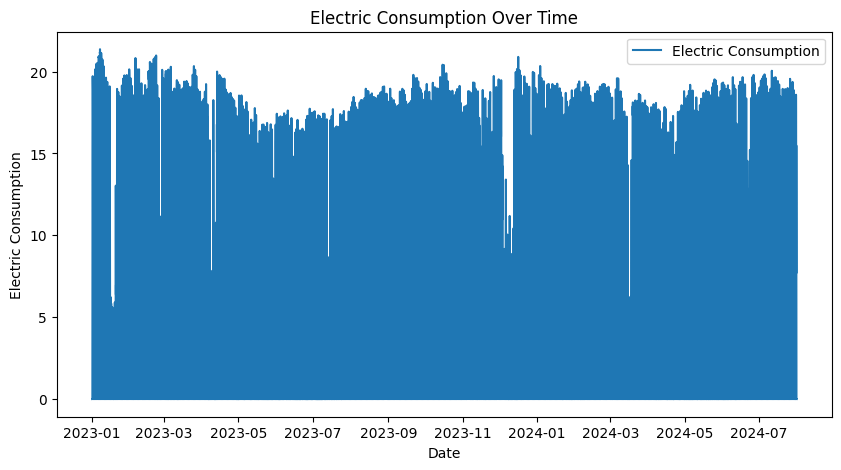

In [3]:
# Plot the Electric Consumption over time
plt.figure(figsize=(10, 5))
plt.plot(train_df['Date'], train_df['Electric_Consumption'], label='Electric Consumption')
plt.title('Electric Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Electric Consumption')
plt.legend()
plt.show()

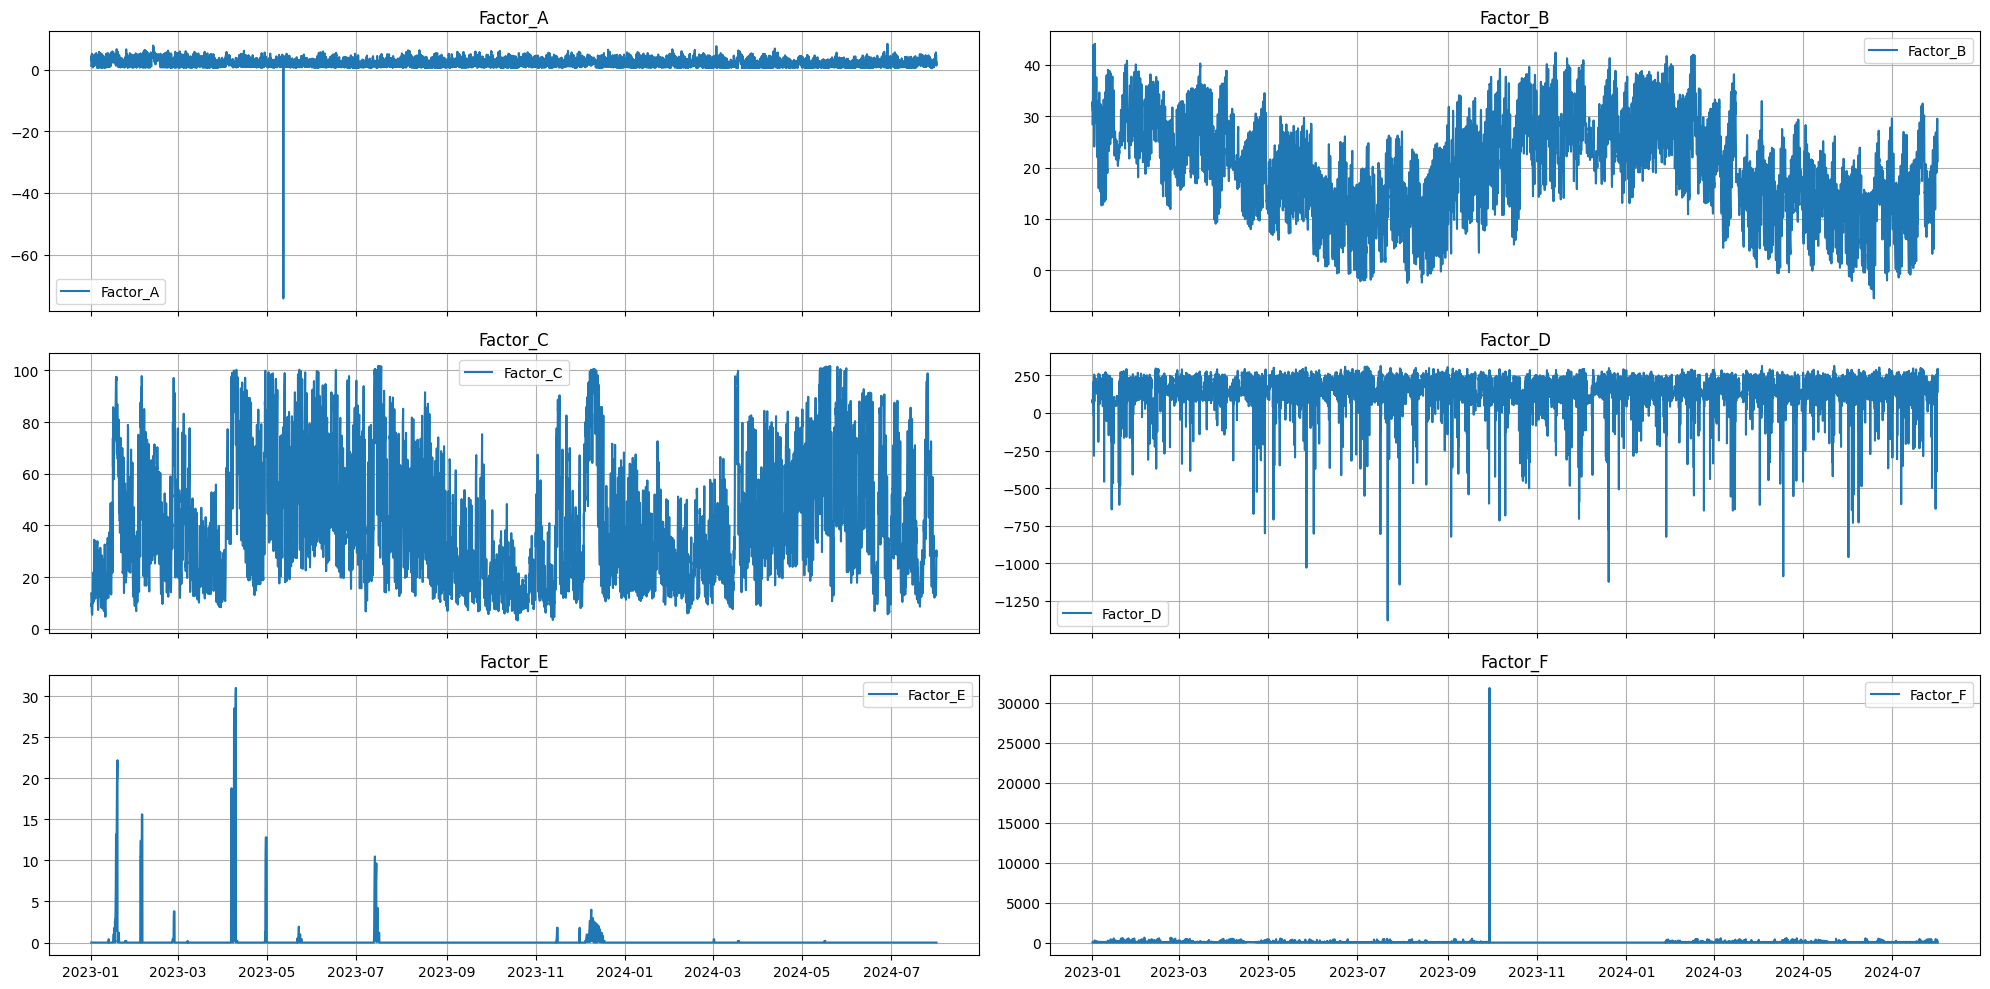

In [4]:
# Feature Visualization: create subplots for different factors over time
fig, axs = plt.subplots(3, 2, figsize=(20, 10), sharex=True)
axs = axs.flatten()

factors = ['Factor_A', 'Factor_B', 'Factor_C', 'Factor_D', 'Factor_E', 'Factor_F']

for i, factor in enumerate(factors):
    axs[i].plot(train_df['Date'], train_df[factor], label=factor)
    axs[i].set_title(factor)
    axs[i].legend()
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Feature Extraction
for df in [train_df, test_df]:
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

test_dates = pd.to_datetime(test_df['Date']) 

# Drop the original Date column
train_df.drop('Date', axis=1, inplace=True)
test_df.drop('Date', axis=1, inplace=True)

features = ['Factor_A', 'Factor_B', 'Factor_C', 'Factor_D', 'Factor_E', 'Factor_F', 'Hour', 'DayOfWeek', 'Month', 'Day']

display(train_df.head())

,Electric_Consumption,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F,Hour,DayOfWeek,Month,Day
0,0.000000,1.242130,28.419739,13.720397,79.840600,0.0,2.386157,0,6,1,1
1,0.000000,1.861285,29.840759,12.537668,86.424903,0.0,1.473256,1,6,1,1
2,0.000000,4.212674,32.778036,9.408667,72.082793,0.0,1.583711,2,6,1,1
3,0.000000,4.025251,32.624700,9.035601,73.825705,0.0,1.706656,3,6,1,1
4,-0.000267,3.122659,31.931245,9.235502,66.823956,0.0,0.987048,4,6,1,1


In [6]:
# Missing Values Check
train_df.isnull().sum().sum()

0

## Outliers Analysis

In [7]:
# Helper functions to display outliers
def boxplt_display(factors):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Boxplots for Each Factor', fontsize=18)
    axes = axes.flatten()

    for i, col in enumerate(factors):
        sns.boxplot(y=train_df[col], ax=axes[i], color='skyblue')
        axes[i].set_title(col, fontsize=12)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Value')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
    plt.show()

def distribution_display(factors):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Distribution Plots for Each Factor', fontsize=18)
    axes = axes.flatten()

    for i, col in enumerate(factors):
        sns.histplot(train_df[col], kde=True, ax=axes[i], color='steelblue')
        axes[i].set_title(f'{col}', fontsize=12)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Frequency')

    for j in range(len(factors), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

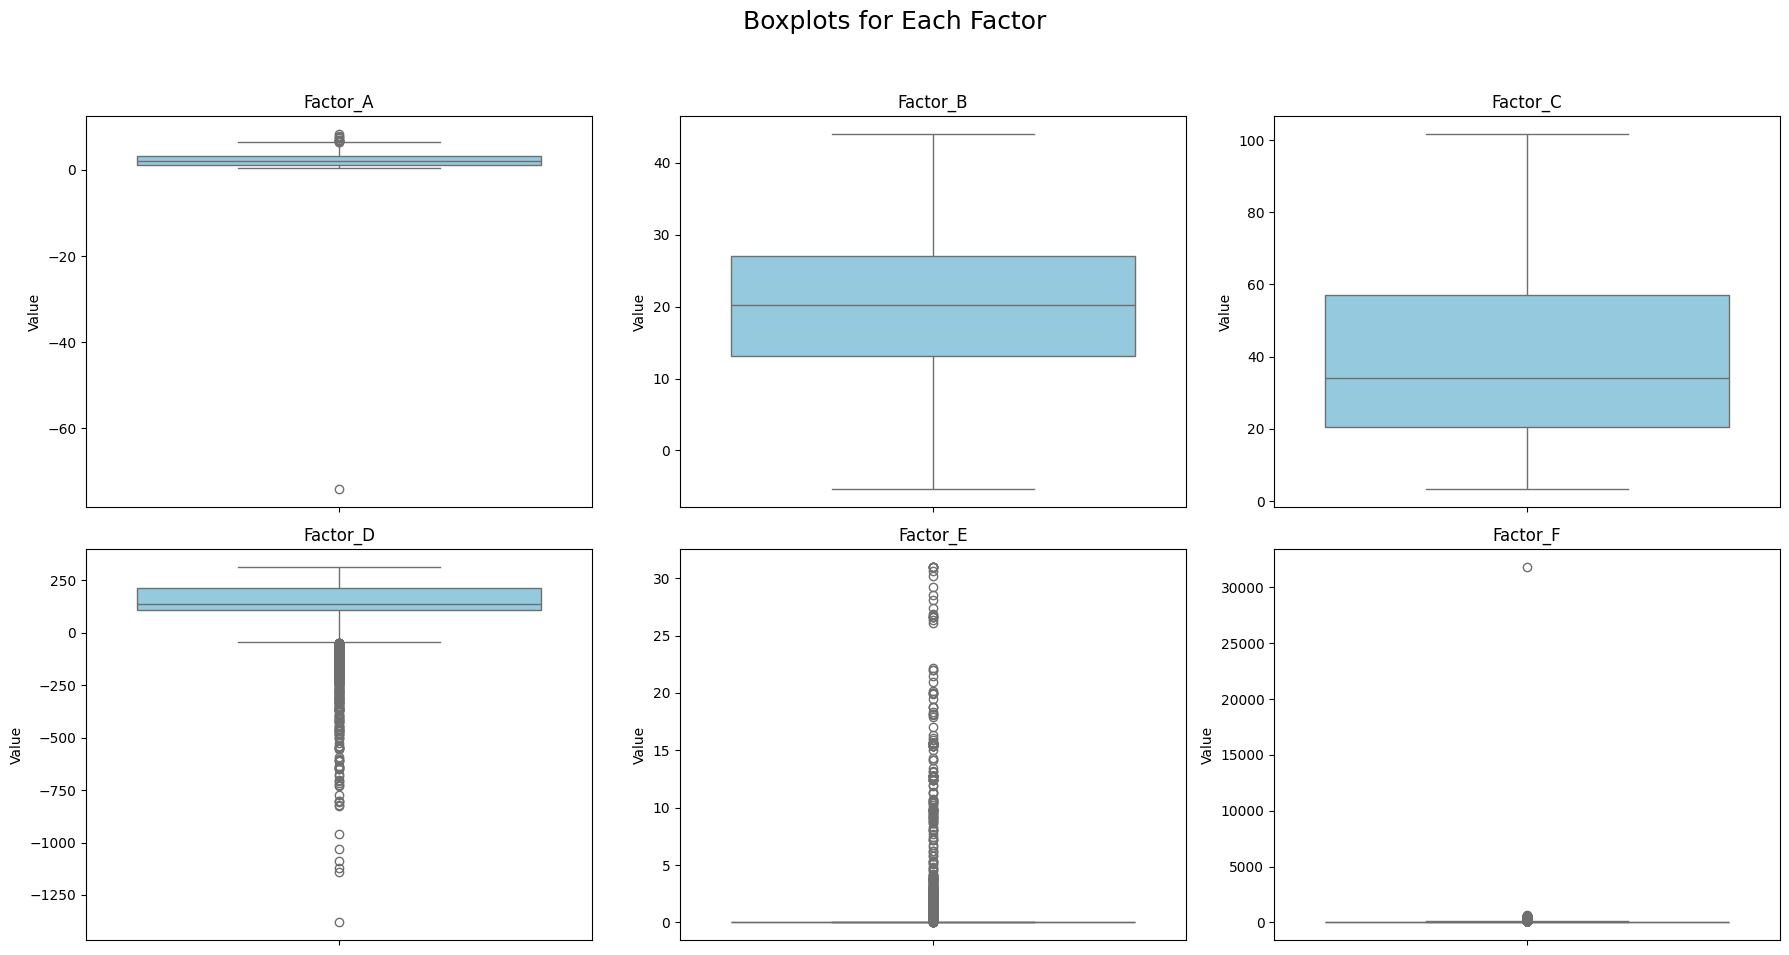

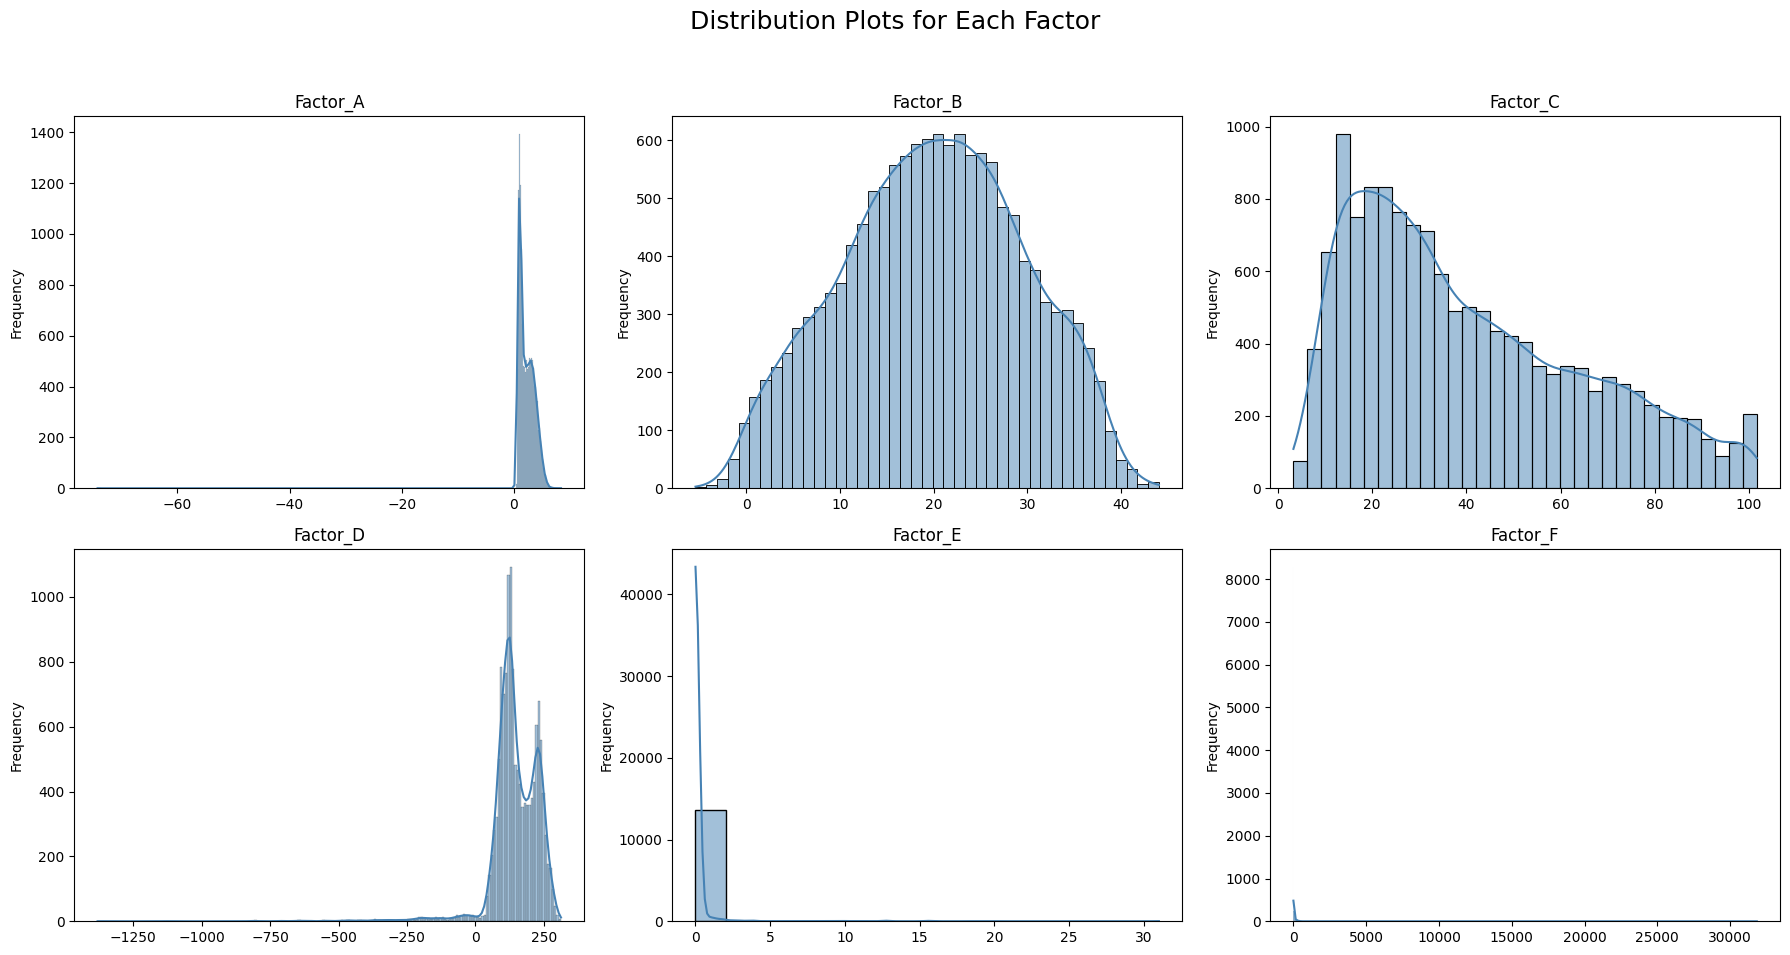

In [8]:
boxplt_display(factors)
distribution_display(factors)

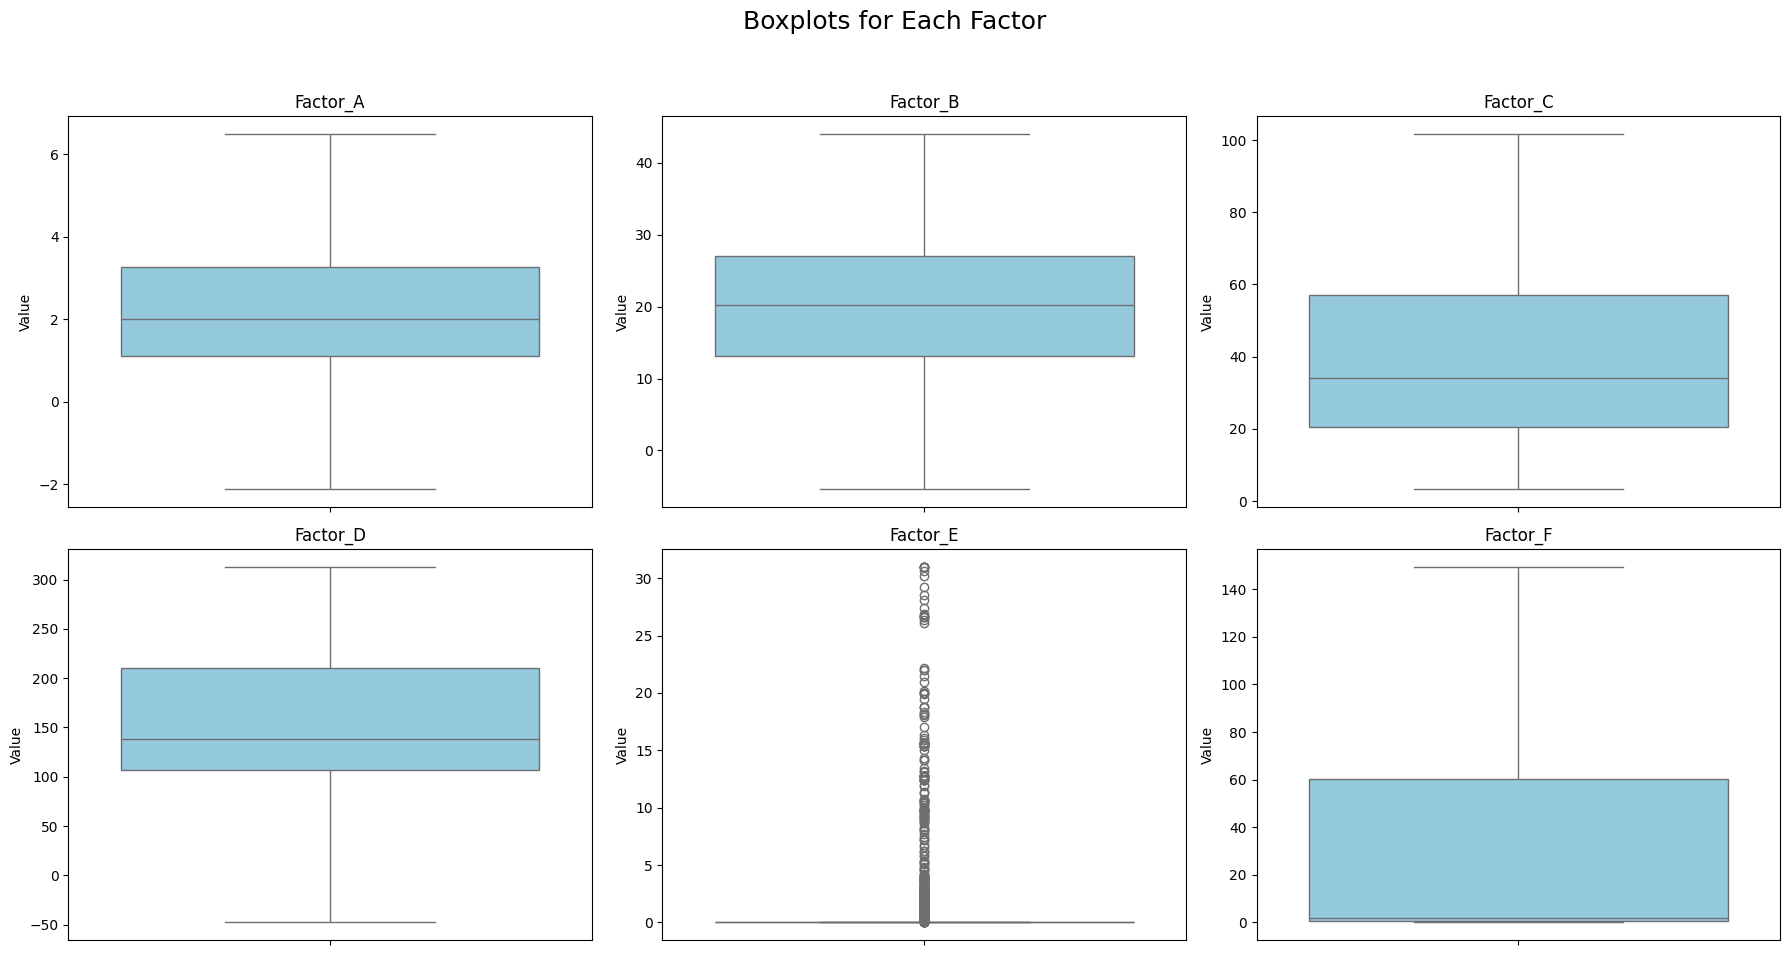

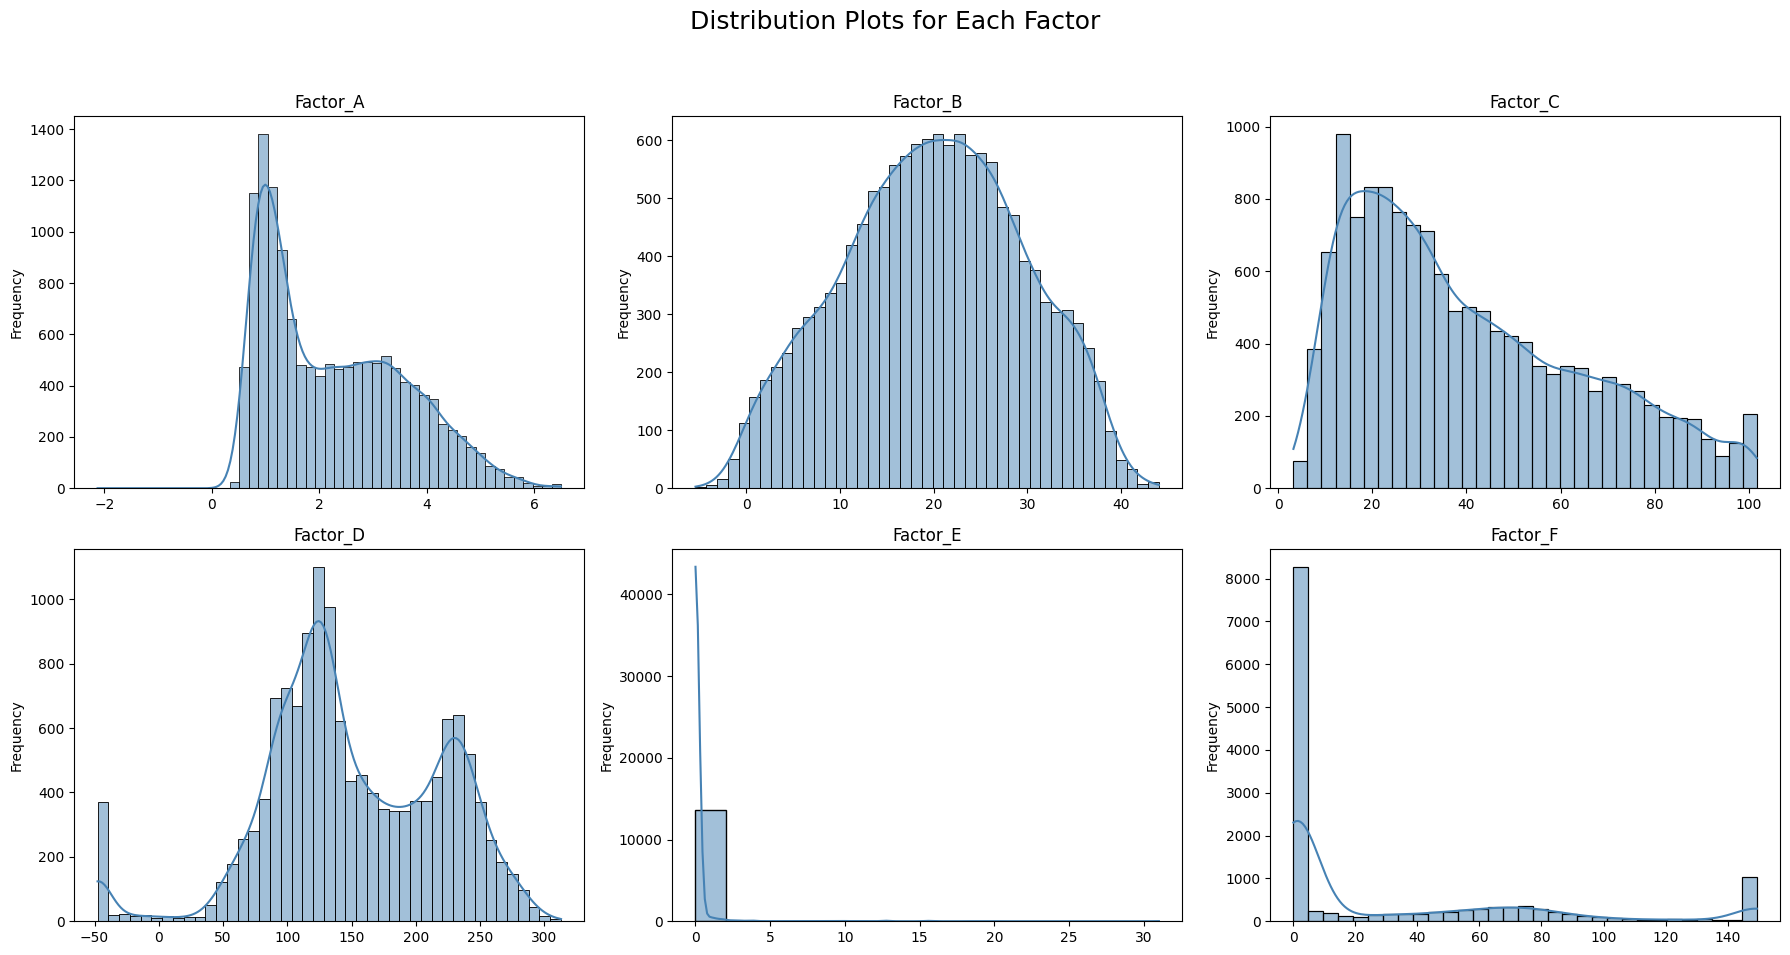

In [9]:
# Detection and Treatment of Outliers in some Factors trhough IQR method
# Assuming that Factor_A, Factor_D and Factor_F are the ones with outliers based on previous boxplot and distribution plots analysis

for col in ['Factor_A', 'Factor_D', 'Factor_F']:
    # IQR calculation
    Q1 = train_df[col].quantile(0.25) 
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Option 1: Clip outliers
    train_df[col] = train_df[col].clip(lower=lower, upper=upper)

    # Option 2: Apply log transform. 
    # train_df[col] = np.log1p(train_df[col] - train_df[col].min() + 1)

    # Trying both methods to see which one works better but the second option raised slightly the RMSE
    
# Check for outliers again
boxplt_display(factors)
distribution_display(factors)

##  Models Training and Evaluation

In [10]:
# Dataset Preparation
X = train_df[features]
y = train_df['Electric_Consumption']
X_test = test_df

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test.head()

,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F,Hour,DayOfWeek,Month,Day
0,1.775026,21.729808,24.808146,249.474701,0.0,1.808403,0,3,8,1
1,2.176429,20.792287,25.128845,241.233210,0.0,1.847753,1,3,8,1
2,2.644089,20.041586,25.045506,239.540034,0.0,1.967446,2,3,8,1
3,2.759897,18.551710,26.976024,238.425577,0.0,2.128126,3,3,8,1
4,2.670419,16.689420,29.611734,240.139421,0.0,1.945275,4,3,8,1


In [11]:
# Helper Functions
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse
    
def plot_feature_importance(model, features, model_name):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances: {model_name}")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()
    
def submission_dataset(predictions, name): 
    name = name.replace(" ", "_")
    output_file = f"..\\Data\\submission_data\\submission_{name}.csv"
    if os.path.exists(output_file):
        os.remove(output_file)
    submission = pd.DataFrame({
        'Date': test_dates, 
        'Electric_Consumption': predictions
        })
    submission.to_csv(output_file, index=False)

    # print(f"File submission_{name}.csv salvato con successo!")

In [12]:
# Models to Compare
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression": make_pipeline(PolynomialFeatures(), LinearRegression()),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
}

pr_param_grid = {
    'polynomialfeatures__degree': [2, 3],
    'polynomialfeatures__include_bias': [False, True],
}

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10, None],
    'min_samples_split': [2, 5],
}

xgb_param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1],
    'tree_method': ['hist'],
    'predictor': ['cpu_predictor'],
}

In [13]:
display(X_train.head())
display(X_test.head())
print("X_train shape",X_train.shape)
print("X_test shape",X_test.shape)
print("y shape",y.shape)

,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F,Hour,DayOfWeek,Month,Day
9205,3.358914,36.536203,12.820157,145.295411,0.0,0.000000e+00,13,4,1,19
6779,2.642509,34.672805,6.255283,251.108846,0.0,2.090000e-43,11,1,10,10
4148,1.239516,14.581460,41.370703,129.642411,0.0,1.550142e+00,20,3,6,22
4436,0.724160,7.163648,36.193505,233.031004,0.0,1.812564e+00,20,1,7,4
13219,1.676083,11.344591,39.577381,136.578953,0.0,1.976420e+00,19,3,7,4


,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F,Hour,DayOfWeek,Month,Day
0,1.775026,21.729808,24.808146,249.474701,0.0,1.808403,0,3,8,1
1,2.176429,20.792287,25.128845,241.233210,0.0,1.847753,1,3,8,1
2,2.644089,20.041586,25.045506,239.540034,0.0,1.967446,2,3,8,1
3,2.759897,18.551710,26.976024,238.425577,0.0,2.128126,3,3,8,1
4,2.670419,16.689420,29.611734,240.139421,0.0,1.945275,4,3,8,1


X_train shape (11097, 10)
X_test shape (2160, 10)
y shape (13872,)



############      Training Linear Regression       ############

Linear Regression Cross-validated RMSE: 4.86 ± 0.66
Linear Regression RMSE: 4.509047174785689

############      Training Polynomial Regression       ############

Polynomial Regression Cross-validated RMSE: 4.19 ± 1.05
Performing grid search for Polynomial Regression ...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Polynomial Regression parameters: {'polynomialfeatures__degree': 3, 'polynomialfeatures__include_bias': False}
Polynomial Regression RMSE: 2.3970789723234143

############      Training Random Forest       ############

Random Forest Cross-validated RMSE: 2.58 ± 0.54
Performing grid search for Random Forest ...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Random Forest parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest RMSE: 1.633206614840841


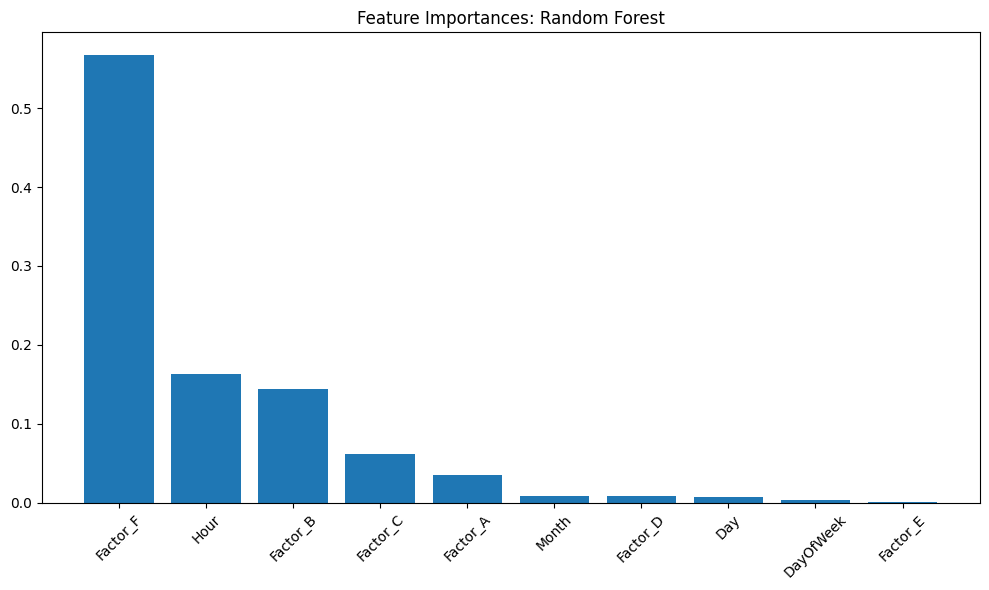


############      Training XGBoost       ############

XGBoost Cross-validated RMSE: 2.78 ± 0.56
Performing grid search for XGBoost ...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\Users\irebu\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [16:07:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost parameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1000, 'predictor': 'cpu_predictor', 'subsample': 0.8, 'tree_method': 'hist'}
XGBoost RMSE: 1.5239462594591227


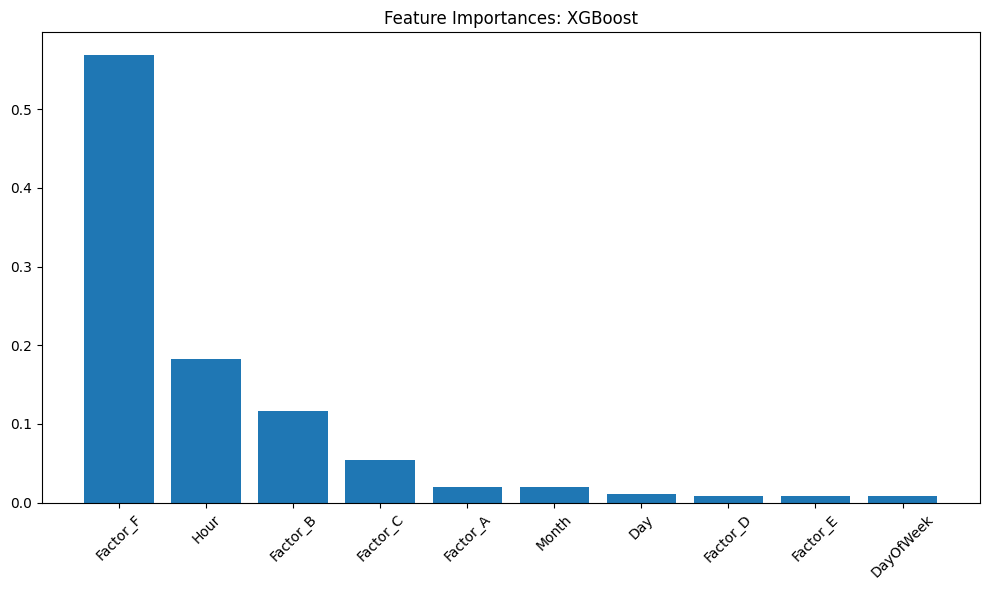

In [14]:
# Training, Validation, and Results
results_dict = {}

for name, model in models.items():

    print(f"\n############      Training {name}       ############\n")
    results_dict[name] = {}
    
    # Cross validation RMSE 
    cv_rmse = rmse_cv(model, X, y)
    print(f"{name} Cross-validated RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}")
    results_dict[name]["cv_rmse"] = cv_rmse.mean()
    results_dict[name]["cv_rmse_std"] = cv_rmse.std()

    if name == "Random Forest": param_grid = rf_param_grid
    elif name == "XGBoost": param_grid = xgb_param_grid
    elif name == "Polynomial Regression": param_grid = pr_param_grid
    else: param_grid = None

    if param_grid:
        
        # Hyperparameter tuning using GridSearchCV
        print(f"Performing grid search for {name} ...")
        grid_model = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, error_score='raise')

        # Fit the model 
        grid_model.fit(X_train, y_train)
        best_model = grid_model.best_estimator_
        best_params = grid_model.best_params_
        print(f"Best {name} parameters: {best_params}")

        results_dict[name]["best_params"] = best_params

    else:
        # Fit the model without hyperparameter tuning
        model.fit(X_train, y_train)
        best_model = model
        results_dict[name]["best_params"] = "Default"

    val_predictions = best_model.predict(X_val)
    val_predictions = np.clip(val_predictions, 0, None) # Ensure predictions are non-negative (We actually have no explanations about the dataset so we can't be sure that negative values are not possible)
    
    rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
    print(f"{name} RMSE: {rmse}")
    results_dict[name]["rmse"] = rmse

    # Feature Importance
    if hasattr(best_model, 'feature_importances_'):
        plot_feature_importance(best_model, features, name)

    # I attempted to improve model performance by removing less important features based on feature importance scores. 
    # Specifically, I experimented with thresholds of 0.05, 0.02, and 0.01 to filter out features with low importance values. 
    # After selecting the most relevant features using each threshold, I retrained the model and evaluated the new RMSE. 
    # However, in all cases, the RMSE increased compared to the original model using all features. 
    # As a result, I decided to keep the full feature set for training, as removing the lower-importance features consistently led to worse performance.
    
    #     important_features = [feature for feature, importance in zip(features, best_model.feature_importances_) 
    #     if importance > 0.01]

    #     if len(important_features) > 0:
    #         # New dataset with important features
    #         X_train_imp = X_train[important_features]
    #         X_val_imp = X_val[important_features]
    #         X_test_imp = X_test[important_features]

    #         # Re-train the model with important features
    #         best_model.fit(X_train_imp, y_train)
    #         val_predictions = best_model.predict(X_val_imp)
    #         print(f"RMSE with selected features: {np.sqrt(mean_squared_error(y_val, val_predictions)):.2f}")

    #         predictions = best_model.predict(X_test_imp)
    #     else:
    #         predictions = best_model.predict(X_test)
    # else:
    
    predictions = best_model.predict(X_test)

    predictions = np.clip(predictions, 0, None)
    submission_dataset(predictions, name)

,Feature,Importance
5,Factor_F,0.569112
6,Hour,0.183055
1,Factor_B,0.116564
2,Factor_C,0.053908
0,Factor_A,0.020362
8,Month,0.019866
9,Day,0.011156
3,Factor_D,0.008965
4,Factor_E,0.008603
7,DayOfWeek,0.008410


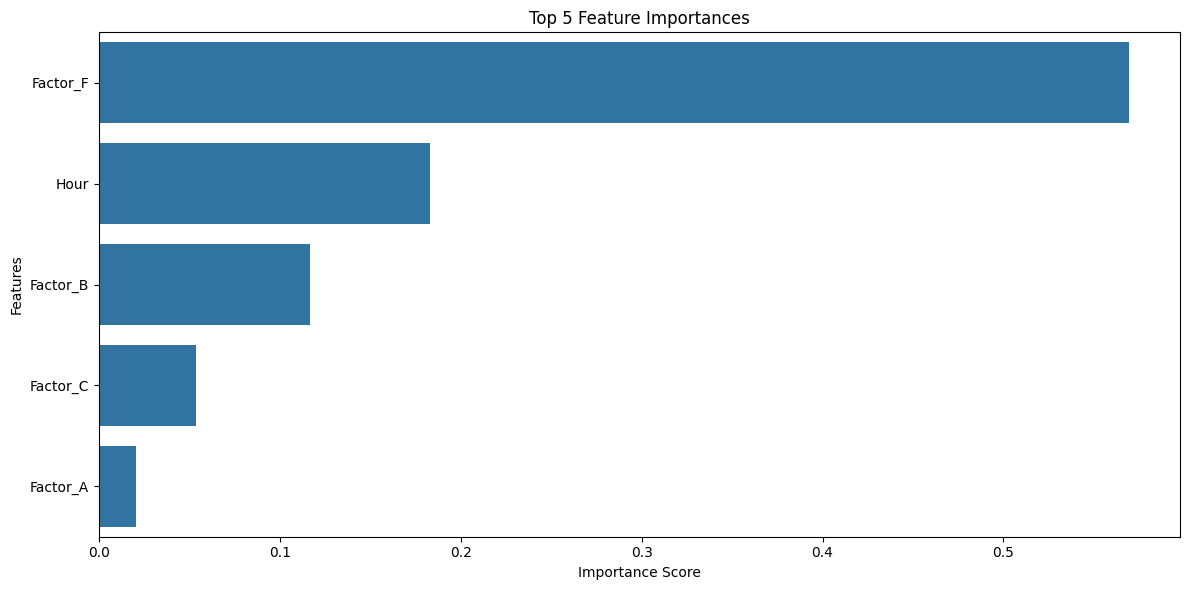

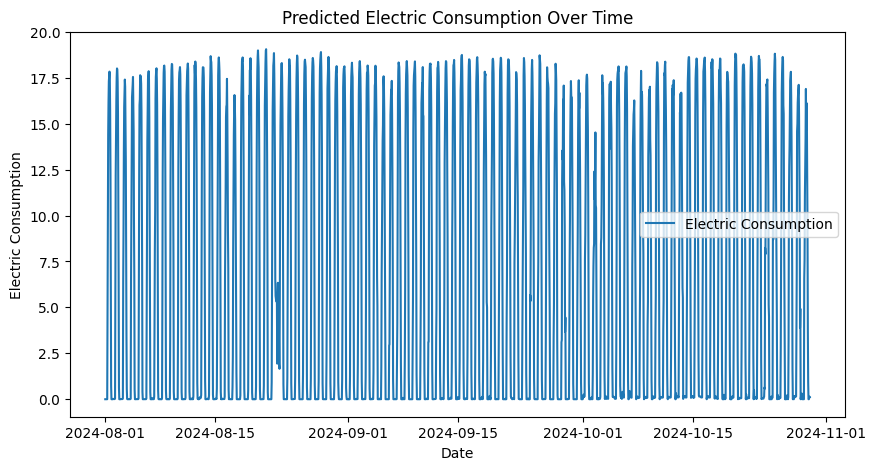

In [15]:
# Get feature importances on the best optimized model - XGBoost
feature_importance = best_model.feature_importances_
features = X.columns

# Create a DataFrame with feature importances of the best model
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

display(importance_df)

# Plot the features by importance using Seaborn of the best model
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(5))  
plt.title('Top 5 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Plot the predictions
plt.figure(figsize=(10, 5))
plt.plot(test_dates, predictions, label='Electric Consumption')
plt.title('Predicted Electric Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Electric Consumption')
plt.legend()
plt.show()

In [16]:
# Compare results 
df = pd.DataFrame(results_dict).T 
df = df[['cv_rmse', 'cv_rmse_std', 'rmse', 'best_params']]
print(df.to_string()) 

                        cv_rmse cv_rmse_std      rmse                                                                                                                           best_params
Linear Regression      4.859008    0.664658  4.509047                                                                                                                               Default
Polynomial Regression  4.190588      1.0516  2.397079                                                          {'polynomialfeatures__degree': 3, 'polynomialfeatures__include_bias': False}
Random Forest          2.583831     0.54346  1.633207                                                                      {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost                2.776065    0.557819  1.523946  {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1000, 'predictor': 'cpu_predictor', 'subsample': 0.8, 'tree_method': 'hist'}
